# Random Effect Logistic Regression by MLMC Variational Bayes

## Model Description

##### Random Effect Models:
For $n=1,...,N$,
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Z_n \sim N(0,\tau^2)$
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Y_{n,t} \sim \text{Bernoulli}\left(\frac{1}{1+\exp(- Z_n - \beta_0 - \beta^T x_{n,t})}\right)$
<br>
for $t=1, ..., T$. This model carries out dimentionality reduction of binary observations $y_{n,k}$'s. Here, the dimention of $\beta$ and $x_{n,t}$ is $D$.<br>
As variational approximation of the posterior $p(z_n|y_n)$, we use $q(z_n)= N(z_n;\mu_n, \sigma_n^2)$

##### Possible Extension:

By adding $\bar x_n=\frac{1}{T}\sum_t x_{n,t}$ to the predictors as 
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Y_{n,t} \sim \text{Bernoulli}\left(\frac{1}{1+\exp(- Z_n - \beta_0 - \beta^T x_{n,t}- \gamma\bar x_n)}\right)$,
<br>
we can obtain correlated random effect models.

#### We do not consider the use of Renyi divergences

## Import Packages

In [1]:
# Turn GPUs off
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
from scipy.stats import bernoulli, norm
from matplotlib import pyplot as plt

In [94]:
tf.test.is_gpu_available()

False

## Utilities

In [3]:
sigmoid = lambda x:1/(1+np.exp(-x))

as_tf_float = lambda x: tf.cast(x, tf.float64)

def tf_logsumexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims)

def tf_logmeanexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims) \
        - tf.math.log(as_tf_float(ary.shape[axis]))

## Generate Toy Dataset

In [4]:
N = 1000
D = 3
T = 2

In [5]:
# data
# We assume that we have infinite amount of data.
# Thus, generator of the data is implemented.
def generate_data(N, D, T, beta0, beta, ln_tau):
    z = np.random.randn(N) * np.exp(ln_tau)
    x = np.random.randn(N*T*D).reshape([N,T,D])
    y = bernoulli(p=sigmoid(beta0+x@beta+z.reshape([N,1]))).rvs()
    return x,y,z

In [6]:
# paramters
ln_tau = np.float64(0.7)
beta0 = np.float64(0.)
beta  = np.random.randn(D) / np.sqrt(D)
param0 = {
    'ln_tau': ln_tau,
    'beta0': beta0,
    'beta': beta
}

In [7]:
x,y,z = generate_data(N, D, T, beta0, beta, ln_tau)

## Sigmoid Normal Integral Approximation of Evidence

Ref: Barber Bishop(1998), PRML(2006)

In [8]:
def sigmoid_normal_prob(x, beta0, beta, ln_tau):
    N, T, D  = x.shape
    kappa = 1 / (1 + np.pi*tf.exp(ln_tau*2)/8)**(1/2)
    return tf.math.sigmoid( kappa * (beta0 + tf.reshape( x@tf.reshape(beta, [D,1]), [N, T])) )

In [9]:
def sigmoid_normal_likelihood(x, y, beta0, beta, ln_tau):
    pred_prob = sigmoid_normal_prob(x, beta0, beta, ln_tau)
    score = tf.reduce_mean(tf.reduce_sum(
        tf.math.log(pred_prob)*y + tf.math.log(1-pred_prob)*(1-y), 
        axis=1))
    return score

## Laplace Approximation of Posterior

In [10]:
def laplace_approx(x, y, beta0, beta, ln_tau):
    N, T, D  = x.shape
    z = np.zeros([N, 1])
    _sig = lambda z: sigmoid( z + beta0 + x@beta )
    for i in range(10):
        sig = _sig(z)
        hessian = 1/np.exp(ln_tau*2) + np.sum( sig*(1-sig), axis=1, keepdims=True)
        grad    = z/np.exp(ln_tau*2) + np.sum( sig - y,     axis=1, keepdims=True)
        z -= grad / hessian
    mu = z.reshape([N])
    sigma = (1 / hessian).reshape([N])**(1/2)
    return mu, sigma

In [11]:
mu, sigma = laplace_approx(x, y, beta0, beta, ln_tau)

In [12]:
z.var(), (z-mu).var()

(4.040722523167153, 2.0913584603307)

## IWELBO approximation of Evidence

In [13]:
def pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma):
    """
    Compute IWELBOs for i = 1,...,n using n_MC samples Zn. 
    Here, we assume that n<N where N is the size of data.
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    z: 1-d array of size [n_MC, N]
    beta: 1-d array of size [D]
    mu: 1-d array of [N]
    sigma**2: 1-d array of [N]
    
    Returns:
    iwelbo: iwelbo, whose size is [N]
    """

    (N, T, D), (n_MC, n) = x.shape, z.shape
    y = as_tf_float( tf.reshape(y, [1,N,T]) )
    mu = tf.reshape(mu, [1,N])
    sigma = tf.reshape(sigma, [1,N])
    
    y_logits = tf.convert_to_tensor( beta0\
                                    + tf.reshape( x@tf.reshape(beta, [D,1]), [1, N, T])\
                                    + tf.reshape(z, [n_MC, N, 1]) 
                                   )
    p_y = tfp.distributions.Bernoulli(logits=y_logits)
    p_z = tfp.distributions.Normal(loc=np.zeros([1, N]), scale=tf.exp(ln_tau))
    q_z = tfp.distributions.Normal(loc=mu, scale=sigma)
    
    log_prob_ratio = \
        tf.reduce_sum( p_y.log_prob(y), axis=2)\
        + p_z.log_prob(z)\
        - q_z.log_prob(z)
    
    iwelbo = tf_logmeanexp(log_prob_ratio, axis=0)
    return iwelbo

In [14]:
def IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC):
    N, = mu.shape
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    iwelbo = tf.reduce_mean( pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma) )
    return iwelbo

In [15]:
signorm_likelihood = sigmoid_normal_likelihood(x, y, beta0, beta, ln_tau).numpy()
elbo_likelihood = IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=1).numpy()
iwelbo_likelihood = IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=64).numpy()

In [126]:
signorm_likelihood, elbo_likelihood, iwelbo_likelihood

(-1.2551747154340933, -1.2160373696810574, -1.2045896910231413)

## Maximum Likelihood by Different Approximation

In [211]:
objectives = {
    "signorm": lambda beta0, beta, ln_tau, mu, sigma: sigmoid_normal_likelihood(x, y, beta0, beta, ln_tau),
    "elbo": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=1),
    "iwelbo8": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=8),
    "iwelbo64": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=64),
    "iwelbo512": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=512)
}
params = {"ground_truth": param0}

N,T,D = (1000, 2, 3) if tf.test.is_gpu_available() else (100, 2, 3)

for obj_name, obj_func in objectives.items():
    
    print("training {}...".format(obj_name))
    
    beta0_ = tf.Variable(0, dtype=tf.float64)
    beta_  = tf.Variable(np.zeros([D]), dtype=tf.float64)
    ln_tau_   = tf.Variable(0, dtype=tf.float64)
    
    # Gradient Descent
    for t in range(2001):
        
        rho_t = 0.5/(1+t)**0.7
        x,y,_ = generate_data(N, D, T, beta0, beta, ln_tau)

        with tf.GradientTape() as g:
            g.watch([beta0_, beta_, ln_tau_])
            mu, sigma = laplace_approx(x, y, beta0_.numpy(), beta_.numpy(), ln_tau_.numpy())
            score = obj_func(beta0_, beta_, ln_tau_, mu, sigma)
        dbeta0_, dbeta_, dln_tau_ = g.gradient(score, [beta0_, beta_, ln_tau_])

        beta0_ = beta0_ + rho_t*dbeta0_
        beta_ = beta_ + rho_t*dbeta_
        ln_tau_ = ln_tau_ + dln_tau_
        if t%200==0:
            print("#iter: {},\tloss: {}".format(t, -score.numpy()))
    
    params[obj_name] = {
        'ln_tau': ln_tau_.numpy(),
        'beta0': beta0_.numpy(),
        'beta': beta_.numpy()
    }
    print()

training signorm...
#iter: 0,	loss: 1.3862943611198904
#iter: 200,	loss: 1.2217970323912979
#iter: 400,	loss: 1.237592319718629
#iter: 600,	loss: 1.3017981438105557
#iter: 800,	loss: 1.27793907350506
#iter: 1000,	loss: 1.293333759457593
#iter: 1200,	loss: 1.2156717556754963
#iter: 1400,	loss: 1.308241073614156
#iter: 1600,	loss: 1.2951134878649435
#iter: 1800,	loss: 1.2591591275898113
#iter: 2000,	loss: 1.2131721435804903

training elbo...
#iter: 0,	loss: 1.3559846013419303
#iter: 200,	loss: 1.352333755944922
#iter: 400,	loss: 1.3232539331865383
#iter: 600,	loss: 1.2142758573708725
#iter: 800,	loss: 1.2728658999639826
#iter: 1000,	loss: 1.252530686934901
#iter: 1200,	loss: 1.3728023136581877
#iter: 1400,	loss: 1.3931981043795685
#iter: 1600,	loss: 1.2946185025280095
#iter: 1800,	loss: 1.312024261335532
#iter: 2000,	loss: 1.2812556448652321

training iwelbo8...
#iter: 0,	loss: 1.3609091796448791
#iter: 200,	loss: 1.20924912331626
#iter: 400,	loss: 1.2273941103203396
#iter: 600,	loss: 1.

In [212]:
def expand(key, val):
    # expand {"name":array([1,2,3,4,5])}
    # into {"name1":1, "name2":2, ..., "name5":5}
    if type(val)==np.ndarray:
        return {key+str(i+1): x for i,x in enumerate(val)} 
    else:
        return {key:val} 

def expand_param(param):
    expanded_param = {}
    for key, val in param.items():
        expanded_param.update(expand(key,val))
    return expanded_param

In [213]:
pd.DataFrame({key: expand_param(param) for key,param in params.items()}).T

,ln_tau,beta0,beta1,beta2,beta3
ground_truth,0.700000,0.000000,-0.618226,-0.661070,0.656738
signorm,-1.031685,-0.001254,-0.382790,-0.413907,0.416211
elbo,-2.617233,0.000441,-0.395766,-0.419168,0.414593
iwelbo8,0.384991,0.002555,-0.521739,-0.546659,0.548213
iwelbo64,0.659334,-0.006210,-0.544958,-0.590992,0.577070
iwelbo512,0.806160,-0.004337,-0.551321,-0.588699,0.583678


##### Bottom Line: IWELBO gives better estiamte than elbo or sigmoid normal integral approximation, even for simple this model. 

In [202]:
class AdamOptimizer:
    
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.ms_and_vs = 'uninitialized'
        self.t = 1
        
    def apply_gradients(self, grads, weights):
        
        if self.ms_and_vs == 'uninitialized':
            self.ms = [0 for _ in weights]
            self.vs = [0 for _ in weights]

        weights_new = []
        ms_new = []
        vs_new = []
        
        for g, w, m, v in zip(grads, weights, self.ms, self.vs):
            m = self.beta1 * m + (1 - self.beta1) * g
            v = self.beta2 * v + (1 - self.beta2) * np.power(g, 2)
            m_hat = m / (1 - np.power(self.beta1, self.t))
            v_hat = v / (1 - np.power(self.beta2, self.t))
            w.assign_sub( self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)  )
            
            ms_new.append(m)
            vs_new.append(v)
            weights_new.append(w)
            
        self.ms = ms_new
        self.vs = vs_new
        self.t += 1
        return weights_new

In [209]:
objectives = {
    "signorm": lambda beta0, beta, ln_tau, mu, sigma: sigmoid_normal_likelihood(x, y, beta0, beta, ln_tau),
    "elbo": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=1),
    "iwelbo8": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=8),
    "iwelbo64": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=64),
    "iwelbo512": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=512)
}
params = {"ground_truth": param0}

N,T,D = 1000 if tf.test.is_gpu_available() else 100, 2, 3

optimizer = AdamOptimizer(learning_rate=0.0003)

for obj_name, obj_func in objectives.items():
    
    print("training {}...".format(obj_name))
    
    beta0_ = tf.Variable(0, dtype=tf.float64)
    beta_  = tf.Variable(np.zeros([D]), dtype=tf.float64)
    ln_tau_   = tf.Variable(0, dtype=tf.float64)
    
    weights = [beta0_, beta_, ln_tau_]
    
    # Adam
    for t in range(2001):
        
        x,y,_ = generate_data(N, D, T, beta0, beta, ln_tau)

        with tf.GradientTape() as g:
            g.watch(weights)
            score = obj_func(*weights, mu, sigma)
            loss = - score
            
        grads = g.gradient(loss, weights)
        optimizer.apply_gradients(grads, weights)
        
        if t%200==0:
            print("#iter: {},\tloss: {}".format(t, -score.numpy()))
    
    params[obj_name] = {
        'ln_tau': ln_tau_.numpy(),
        'beta0': beta0_.numpy(),
        'beta': beta_.numpy()
    }
    print()

training signorm...
#iter: 0,	loss: 1.3862943611198904
#iter: 200,	loss: 1.3551366335215687
#iter: 400,	loss: 1.3161046370038891
#iter: 600,	loss: 1.292064100559634
#iter: 800,	loss: 1.2549904949612898
#iter: 1000,	loss: 1.306765028729184
#iter: 1200,	loss: 1.3057486276918246
#iter: 1400,	loss: 1.3383679797877923
#iter: 1600,	loss: 1.2904242818107678
#iter: 1800,	loss: 1.3044501919772995
#iter: 2000,	loss: 1.3672212871118155

training elbo...
#iter: 0,	loss: 1.9059660546817634
#iter: 200,	loss: 1.758962148718304
#iter: 400,	loss: 1.7240334886935704
#iter: 600,	loss: 1.3957022926594274
#iter: 800,	loss: 1.3907655813152235
#iter: 1000,	loss: 1.3791367111618758
#iter: 1200,	loss: 1.4455348164718256
#iter: 1400,	loss: 1.3150371548992927
#iter: 1600,	loss: 1.359940167436805
#iter: 1800,	loss: 1.3227918753386971
#iter: 2000,	loss: 1.34352729767596

training iwelbo8...
#iter: 0,	loss: 1.7776374362884935
#iter: 200,	loss: 1.4915073884367767
#iter: 400,	loss: 1.411943190960556
#iter: 600,	loss:

In [210]:
pd.DataFrame({key: expand_param(param) for key,param in params.items()}).T

,ln_tau,beta0,beta1,beta2,beta3
ground_truth,0.700000,0.000000,-0.618226,-0.661070,0.656738
signorm,-0.544431,-0.004982,-0.398758,-0.433869,0.427887
elbo,-0.978721,0.009331,-0.379436,-0.410909,0.418437
iwelbo8,-1.025497,-0.004721,-0.381419,-0.424836,0.417281
iwelbo64,-0.880616,0.000940,-0.397441,-0.429447,0.419870
iwelbo512,-0.697200,0.003073,-0.406940,-0.425994,0.437277


#### Adam does not work at all

## MLMC

In [25]:
def pointwise_dIWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma):
    
    (N, T, D), (n_MC, N) = x.shape, z.shape
    assert np.log2(n_MC)%1==0
    
    if n_MC == 1:
        scores = pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma)
    else:
        scores = pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma)
        scores -= (1/2.) * pointwise_IWELBO(x, y, z[:n_MC//2 ], beta0, beta, ln_tau, mu, sigma)
        scores -= (1/2.) * pointwise_IWELBO(x, y, z[ n_MC//2:], beta0, beta, ln_tau, mu, sigma)
    return scores

In [26]:
def dIWELBO(x, y, beta0, beta, ln_tau, mu, sigma, level):
    
    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    
    diwelbo = tf.reduce_mean( pointwise_dIWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma) )
    return diwelbo

In [27]:
tf.random.normal(mean=[0,1], stddev=[0.1,1], shape=[3,2])

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 0.14800048,  2.90518   ],
       [-0.07132575,  1.7107816 ],
       [ 0.06704418, -0.21650064]], dtype=float32)>

In [64]:
def IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=8, w0=1-2.**(-3/2), b=2, randomize=False):
    
    N, T, D = x.shape

    levels = np.arange(max_level)
    weights = 2.**(-(b+1)/2*levels)
    weights /= sum(weights)
    weights = np.concatenate([[w0], (1-w0)*weights])
    
    if randomize==True:
         Ns = np.random.multinomial(n=N, pvals=weights)
        
    elif randomize==False:
        Ns = np.zeros_like(levels)
        Ns = np.array([np.math.ceil(w*N) for w in weights], dtype=np.int)
        Ns[0] = N - sum(Ns[1:])
    
    else:
        raise(Exception("Invarid argument for 'randomize' of function IWELBO_MLMC. It must be True or False."))
    
    N_offset = 0
    score = 0
    for i, l in enumerate(levels):
        if Ns[i]==0:
            continue
        x_tmp = x[N_offset:N_offset+Ns[i]]
        y_tmp = y[N_offset:N_offset+Ns[i]]
        mu_tmp = mu[N_offset:N_offset+Ns[i]]
        sigma_tmp = sigma[N_offset:N_offset+Ns[i]]
                       
        if randomize==True:
            score += dIWELBO(x_tmp, y_tmp, beta0, beta, ln_tau, mu_tmp, sigma_tmp, level=l) * Ns[i] / N / weights[i]   
        elif randomize==False:
            score += dIWELBO(x_tmp, y_tmp, beta0, beta, ln_tau, mu_tmp, sigma_tmp, level=l)
        
        N_offset += Ns[i]
    return score

In [29]:
IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=10, w0=0.90, randomize=True)

<tf.Tensor: shape=(), dtype=float64, numpy=-1.2507511357956038>

In [30]:
IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=64)

<tf.Tensor: shape=(), dtype=float64, numpy=-1.2222752474444256>

## MLMC codition check for objective

In [31]:
def conv_stats_dIWELBO(x, y, beta0, beta, ln_tau, mu, sigma, level=1):
    
    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    
    diwelbos = pointwise_dIWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma).numpy()
    iwelbos = pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma).numpy()
    
    return {'mean_dIWELBO':np.mean(diwelbos), 
            'mean_abs_dIWELBO':np.mean(np.abs(diwelbos)), 
            'mean_squared_dIWELBO':np.mean(diwelbos**2),
            'var_dIWELBO':np.var(diwelbos), 
            'var_IWELBO':np.var(iwelbos)}

In [33]:
def tmp(l):
    N0 = 2000000
    x,y,_ = generate_data(N=N0//2**l, D=3, T=2, beta0=beta0, beta=beta, ln_tau=ln_tau)
    mu, sigma = laplace_approx(x, y, beta0, beta, ln_tau)
    return conv_stats_dIWELBO(x, y, beta0, beta, ln_tau, mu, sigma, level=l)

conv_stats = [tmp(l) for l in range(10)]
conv_stats = pd.DataFrame(conv_stats)

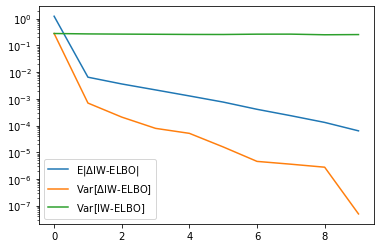

In [34]:
plt.plot(conv_stats[['mean_abs_dIWELBO', 'var_dIWELBO', 'var_IWELBO']])
plt.legend([r'$\mathrm{E} | \Delta \mathrm{IW}$-$\mathrm{ELBO}|$', 
            r'$\mathrm{Var}[\Delta \mathrm{IW}$-$\mathrm{ELBO}]$', 
            r'$\mathrm{Var}[\mathrm{IW}$-$\mathrm{ELBO}]$'])
plt.yscale('log')

In [35]:
conv_stats

,mean_dIWELBO,mean_abs_dIWELBO,mean_squared_dIWELBO,var_dIWELBO,var_IWELBO
0,-1.232805,1.234559,1.798791e+00,2.789842e-01,0.278984
1,0.006465,0.006465,7.374356e-04,6.956457e-04,0.269283
2,0.003608,0.003608,2.205888e-04,2.075699e-04,0.264818
3,0.002160,0.002160,8.327397e-05,7.860695e-05,0.261204
4,0.001286,0.001286,5.282083e-05,5.116791e-05,0.257436
5,0.000757,0.000757,1.643310e-05,1.585988e-05,0.256269
6,0.000406,0.000406,4.732589e-06,4.567600e-06,0.263609
7,0.000234,0.000234,3.641679e-06,3.586863e-06,0.264146
8,0.000131,0.000131,2.786725e-06,2.769487e-06,0.250253
9,0.000064,0.000064,5.348454e-08,4.945005e-08,0.254525


## MLMC codition check for gradients

In [36]:
def conv_stats_grad_dIWELBO(x, y, beta0, beta, ln_tau, mu, sigma, level=1):
    
    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N]).T
    
    param = tf.concat([beta, [beta0], [ln_tau]], axis=0)
    param = tf.Variable(param, dtype=tf.float64)
    params = tf.reshape(param, [1,D+2]) * np.ones([N,1])

    mu, sigma = laplace_approx(x, y, beta0, beta, ln_tau)        
    
    def get_grad(args):
        
        param, x_, y_, z_, mu, sigma = args
        z_ = tf.reshape(z_, [-1,1])
        
        with tf.GradientTape(persistent=True) as g:
            g.watch(param)
            beta_ = param[0,:D]
            beta0_ = param[0,D]
            ln_tau_ = param[0,D+1]
            diwelbos = pointwise_dIWELBO(x_, y_, z_, beta0_, beta_, ln_tau_, mu, sigma)
            iwelbos = pointwise_IWELBO(x_, y_, z_, beta0_, beta_, ln_tau_, mu, sigma)
            
        a = g.gradient(diwelbos, param)
        b = g.gradient(iwelbos, param)
        
        del g
        
        return a,b
    
    args = [tf.expand_dims(arg, axis=1) for arg in [params, x, y, z, mu, sigma]]
    grads = tf.vectorized_map(get_grad, args)
    
    grad_diwelbos = tf.squeeze(grads[0])
    grad_iwelbos = tf.squeeze(grads[1])
    
    return {'norm_mean_grad_dIWELBO': np.linalg.norm(np.mean(grad_diwelbos, axis=0)), 
            'mean_norm_grad_dIWELBO': np.mean(np.linalg.norm(grad_diwelbos, axis=1)), 
            'mean_squared_norm_grad_dIWELBO': np.mean(np.linalg.norm(grad_diwelbos, axis=1)**2),
            'trace_covariance_grad_dIWELBO': np.sum(np.var(grad_diwelbos, axis=0)), 
            'trace_covariance_grad_IWELBO': np.sum(np.var(grad_iwelbos, axis=0))}

In [37]:
def tmp(l):
    N0 = 2000000
    x,y,_ = generate_data(N=N0//2**l, D=3, T=2, beta0=beta0, beta=beta, ln_tau=ln_tau)
    mu, sigma = laplace_approx(x, y, beta0, beta, ln_tau)
    return conv_stats_grad_dIWELBO(x, y, beta0, beta, ln_tau, mu, sigma, level=l)

conv_stats = [tmp(l) for l in range(10)]
conv_stats = pd.DataFrame(conv_stats)

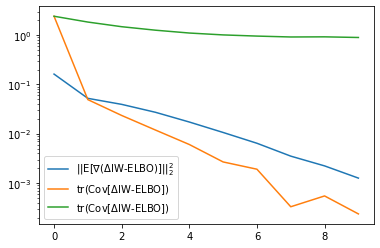

In [63]:
plt.plot(conv_stats[['norm_mean_grad_dIWELBO', 'trace_covariance_grad_dIWELBO', 'trace_covariance_grad_IWELBO']])
plt.legend([r'$||\mathrm{E} [\nabla (\Delta \mathrm{IW}$-$\mathrm{ELBO})]||_2^2$', 
            r'$\mathrm{tr}(\mathrm{Cov}[\Delta \mathrm{IW}$-$\mathrm{ELBO}])$', 
            r'$\mathrm{tr}(\mathrm{Cov}[\Delta \mathrm{IW}$-$\mathrm{ELBO}])$'])
plt.yscale('log')

$b\approx1$ for $V_\ell\propto 2^{-b\ell}$!?

In [39]:
conv_stats

,norm_mean_grad_dIWELBO,mean_norm_grad_dIWELBO,mean_squared_norm_grad_dIWELBO,trace_covariance_grad_dIWELBO,trace_covariance_grad_IWELBO
0,0.161872,1.350972,2.436254,2.410052,2.410052
1,0.052166,0.075348,0.051878,0.049157,1.837297
2,0.039383,0.048425,0.025012,0.023461,1.478819
3,0.027193,0.031394,0.012612,0.011872,1.256417
4,0.017273,0.019341,0.006346,0.006047,1.100748
5,0.010605,0.011623,0.002791,0.002678,1.008295
6,0.006407,0.006927,0.001949,0.001907,0.954304
7,0.003513,0.003770,0.000343,0.000331,0.915277
8,0.002227,0.002354,0.000553,0.000548,0.921422
9,0.001259,0.001327,0.000238,0.000237,0.893999


## Cost comparison of objective

In [65]:
NMC_ests = []
MLMC_ests = []
RandMLMC_ests = []
for i in range(100):
    N0 = 4000
    x,y,_ = generate_data(N=N0, D=3, T=2, beta0=beta0, beta=beta, ln_tau=ln_tau)
    mu, sigma = laplace_approx(x, y, beta0, beta, ln_tau)
    NMC_ests.append( IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=512).numpy() )
    MLMC_ests.append( IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=9, w0=0.90, randomize=False).numpy() )
    RandMLMC_ests.append( IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=9, w0=0.90, randomize=True).numpy() )

In [66]:
print("std-div of NMC estimator:      ", np.std(NMC_ests))
print("std-div of MLMC estimator:     ", np.std(MLMC_ests))
print("std-div of RandMLMC estimator: ", np.std(RandMLMC_ests))

std-div of NMC estimator:       0.0024924731194345654
std-div of MLMC estimator:      0.0027603319503505283
std-div of RandMLMC estimator:  0.003223633615106453


In [56]:
%%timeit
IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=2**9)

2.12 s ± 5.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
%%timeit
IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=9, w0=0.90, randomize=False)

73.5 ms ± 441 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [58]:
%%timeit
IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=9, w0=0.90, randomize=True)

73.4 ms ± 629 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Cost comparison of gradients

In [87]:
NMC_ests = []
MLMC_ests = []
RandMLMC_ests = []
for i in range(100):
    N0 = 2000
    x,y,_ = generate_data(N=N0, D=3, T=2, beta0=beta0, beta=beta, ln_tau=ln_tau)
    mu, sigma = laplace_approx(x, y, beta0, beta, ln_tau)
    
    param = tf.concat([beta, [beta0], [ln_tau]], axis=0)
    param = tf.Variable(param, dtype=tf.float64)
    
    with tf.GradientTape(persistent=True) as g:
        g.watch(param)
        beta_ = param[:D]
        beta0_ = param[D]
        ln_tau_ = param[D+1]
        nmc_est = IWELBO(x, y, beta0_, beta_, ln_tau_, mu, sigma, n_MC=2**12)
        mlmc_est = IWELBO_MLMC(x, y, beta0_, beta_, ln_tau_, mu, sigma, max_level=12, w0=0.8, b=1,  randomize=False)
        randmlmc_est = IWELBO_MLMC(x, y, beta0_, beta_, ln_tau_, mu, sigma, max_level=12, w0=0.8, b=1, randomize=True)
            
    nmc_est = g.gradient(nmc_est, param)
    mlmc_est = g.gradient(mlmc_est, param)
    randmlmc_est = g.gradient(randmlmc_est, param)
    
    del g
        
    NMC_ests.append( nmc_est )
    MLMC_ests.append( mlmc_est )
    RandMLMC_ests.append( randmlmc_est )

In [88]:
print("E||grad||^2 of NMC estimator:      ", np.mean(np.linalg.norm(NMC_ests)))
print("E||grad||^2 of MLMC estimator:     ", np.mean(np.linalg.norm(MLMC_ests)))
print("E||grad||^2 of RandMLMC estimator: ", np.mean(np.linalg.norm(RandMLMC_ests)))

E||grad||^2 of NMC estimator:       0.21549826403397726
E||grad||^2 of MLMC estimator:      0.5024365180633751
E||grad||^2 of RandMLMC estimator:  0.544721565232442


In [89]:
%%timeit
with tf.GradientTape(persistent=True) as g:
    g.watch(param)
    beta_ = param[:D]
    beta0_ = param[D]
    ln_tau_ = param[D+1]
    nmc_est = IWELBO(x, y, beta0_, beta_, ln_tau_, mu, sigma, n_MC=2**12)

nmc_est = g.gradient(nmc_est, param)

1.22 s ± 6.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [92]:
%%timeit
with tf.GradientTape(persistent=True) as g:
    g.watch(param)
    beta_ = param[:D]
    beta0_ = param[D]
    ln_tau_ = param[D+1]
    mlmc_est = IWELBO_MLMC(x, y, beta0_, beta_, ln_tau_, mu, sigma, max_level=12, w0=0.8, b=1, randomize=False)

mlmc_est = g.gradient(mlmc_est, param)

164 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [93]:
%%timeit
with tf.GradientTape(persistent=True) as g:
    g.watch(param)
    beta_ = param[:D]
    beta0_ = param[D]
    ln_tau_ = param[D+1]
    randmlmc_est = IWELBO_MLMC(x, y, beta0_, beta_, ln_tau_, mu, sigma, max_level=12, w0=0.8, b=1, randomize=True)

randmlmc_est = g.gradient(randmlmc_est, param)

137 ms ± 6.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### For finding nice configuration where MLMC wins NMC 

In [ ]:
N,_ = y.shape
n_MC = 2
z = norm(loc=mu, scale=sigma).rvs([n_MC, N])

diwelbos = pointwise_dIWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma).numpy()
score1 = np.var(NMC_ests) / diwelbos.mean()**2
score2 = np.var(MLMC_ests) / np.var(NMC_ests)
print(score1, score2)

print(np.std(x@beta, axis=1).mean(), z.std())